In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

TF_ENABLE_ONEDNN_OPTS=1

# Training a simple binary classification model

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

train_labels_is0 = []
for label in train_labels:
    train_labels_is0.append(int(not(bool(label))))
train_labels_is0 = np.array(train_labels_is0, dtype="float32")

test_labels_is0 = []
for label in test_labels:
    test_labels_is0.append(int(not(bool(label))))
test_labels_is0 = np.array(test_labels_is0, dtype="float32")

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
is0_input = layers.Input(shape=28*28)
is0_layer1 = layers.Dense(1, activation="sigmoid")
is0_output = is0_layer1(is0_input)

is0_model = keras.Model(inputs = is0_input,
                        outputs = is0_output,
                        name="is0")

In [4]:
is0_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

In [5]:
history = is0_model.fit(train_images, train_labels_is0, 
                        validation_split=0.2, 
                        epochs=50, batch_size=128)

Epoch 1/50
375/375 [==============================] - 5s 4ms/step - loss: 0.1262 - binary_accuracy: 0.9641 - val_loss: 0.0479 - val_binary_accuracy: 0.9874
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0411 - binary_accuracy: 0.9893 - val_loss: 0.0347 - val_binary_accuracy: 0.9908
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0340 - binary_accuracy: 0.9906 - val_loss: 0.0314 - val_binary_accuracy: 0.9913
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0311 - binary_accuracy: 0.9907 - val_loss: 0.0290 - val_binary_accuracy: 0.9910
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0295 - binary_accuracy: 0.9914 - val_loss: 0.0284 - val_binary_accuracy: 0.9903
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0284 - binary_accuracy: 0.9914 - val_loss: 0.0275 - val_binary_accuracy: 0.9913
Epoch 7/50
375/375 [==============================] - 1s 3ms/ste

In [6]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

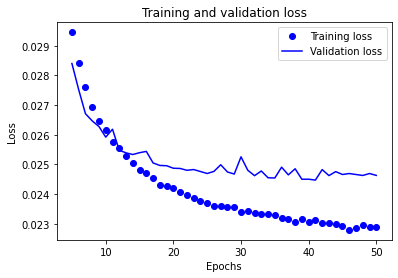

In [7]:
history_dict = history.history
loss_values = history_dict["loss"]
start = 5
val_loss_values = history_dict["val_loss"]
epochs = range(start, len(loss_values) + 1)
plt.plot(epochs, loss_values[start-1:], "bo", label="Training loss")
plt.plot(epochs, val_loss_values[start-1:], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

You can draw 2 conclusions from this plot:

1_ The model performance plateaus after ~25 epochs

2_ The model is too restricted to significantly overfit to our training data

Now let us check how the model performs on our test data.

In [8]:
is0_model.evaluate(test_images, test_labels_is0)

313/313 [==============================] - 1s 2ms/step - loss: 0.0248 - binary_accuracy: 0.9920


[0.024835295975208282, 0.9919999837875366]

In [9]:
weights = is0_model.layers[1].get_weights()[0]
weights = weights + abs(weights.min())
weights = weights.reshape(28,28)

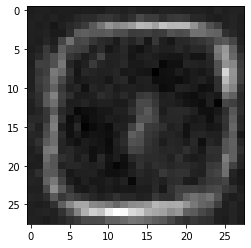

In [10]:
plt.imshow(weights, cmap=plt.cm.binary)
plt.show()

# Manual feature selection

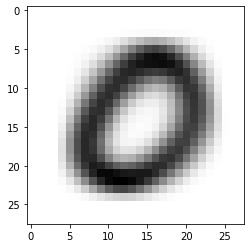

In [13]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

zero_indices = np.where(train_labels==0)
average_zero_image = np.average(train_images[zero_indices],axis=0)

digit = average_zero_image
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
average_zero_image = average_zero_image.reshape((28 * 28,))
average_zero_image = average_zero_image.astype("float32") / 255

In [15]:
train_labels_is0 = []
for label in train_labels:
    train_labels_is0.append(int(not(bool(label))))
train_labels_is0 = np.array(train_labels_is0, dtype="float32")

test_labels_is0 = []
for label in test_labels:
    test_labels_is0.append(int(not(bool(label))))
test_labels_is0 = np.array(test_labels_is0, dtype="float32")

To assign weights to our features based on average_zero_image we need 3 new hyper parameters: 

1_ threshold : the shade of gray above which the corresponding weight is positive

2_ bt_weight : the weight associated with gray pixels below threshold

3_ zero_weight : the weight associated with the white pixels


In [16]:
threshold = 0.3
bt_weight = -1
zero_weight = -5

av_zero_zeros = []
av_zero_at = []
av_zero_bt = []

for i in range(28*28):
    if average_zero_image[i] == 0:
        av_zero_zeros.append(i)
    elif average_zero_image[i] >= threshold:
        av_zero_at.append(i)
    else:
        av_zero_bt.append(i)

In [17]:
new_weights_weights = np.copy(average_zero_image)
new_weights_weights[av_zero_zeros] += zero_weight
new_weights_weights[av_zero_at] = np.ones(len(av_zero_at),dtype="float32")
new_weights_weights[av_zero_bt] = bt_weight*np.ones(len(av_zero_bt),dtype="float32")

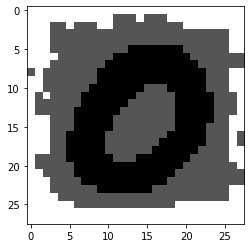

In [18]:
plt.imshow((new_weights_weights - zero_weight).reshape(28,28), cmap=plt.cm.binary)
plt.show()

In [19]:
weightdotinput = []
for image in train_images:
    weightdotinput.append(np.dot(new_weights_weights, image))
weightdotinput = np.array(weightdotinput)

nonzero_indices = np.delete(np.arange(train_labels.shape[0]),zero_indices)
dist0 = weightdotinput[zero_indices].astype(int)
dist1 = weightdotinput[nonzero_indices].astype(int)

n_bins0 = dist0.max() - dist0.min()
n_bins1 = dist1.max() - dist1.min()

(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 5.000e+00, 8.000e+00,
        8.000e+00, 1.200e+01, 1.000e+01, 1.300e+01, 1.700e+01, 2.800e+01,
        3.100e+01, 2.500e+01, 3.900e+01, 3.900e+01, 4.000e+01, 4.100e+01,
        7.400e+01, 7.600e+01, 9.000e+01, 8.800e+01, 1.320e+02, 1.390e+02,
        1.960e+02, 2.020e+02, 2.170e+02, 2.930e+02, 3.330e+02, 3.830e+02,
        4.670e+02, 5.820e+02, 7.000e+02, 7.850e+02, 8.770e+02, 9.240e+02,
        1.020e+03, 9.650e+02, 2.049e+03, 1.110e+03, 1.104e+03, 1.220e+03,
        1.073e+03, 1.100e+03, 9.960e+02, 1.010e+03, 1.023e+03, 9.550e+02,
        9.100e+02, 9.360e+02, 9.570e+02, 9.670e+02, 9.740e+02, 9.480e+02,
        9.410e+02, 9.180e+02, 9.630e+02, 9.640e+02, 9.550e+02, 8.910e+02,
        9.280e+02, 9.200e+02, 8.950e+02, 8.350e+02, 8.980e+02, 8.430e+02,
        7.610e+02, 7.710e+02, 7.810e+0

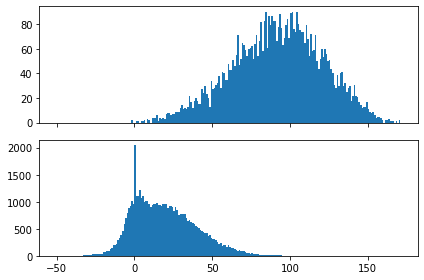

In [20]:
fig, axs = plt.subplots(2,sharex=True, tight_layout=True)
axs[0].hist(dist0, bins=n_bins0)
axs[1].hist(dist1, bins=n_bins1)

In [22]:
b = 0.

In [23]:
is0_input = layers.Input(shape=28*28)
is0_train_layer = layers.Dense(1)
is0_output_layer = layers.Dense(1, activation="sigmoid")
is0_output = is0_output_layer(is0_train_layer(is0_input))

is0_model = keras.Model(inputs = is0_input,
                        outputs = is0_output,
                        name="is0")

is0_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

In [24]:
is0_model.layers[1].trainable=False
is0_model.summary()

Model: "is0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 785       
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 787
Trainable params: 2
Non-trainable params: 785
_________________________________________________________________


In [25]:
is0_model.layers[1].get_weights()

[array([[-0.03399324],
        [ 0.04948314],
        [-0.00260179],
        [ 0.03145675],
        [ 0.07368417],
        [-0.03683016],
        [-0.0699769 ],
        [ 0.03133023],
        [ 0.02179085],
        [-0.02682757],
        [-0.03596737],
        [-0.04234872],
        [-0.0351033 ],
        [-0.04139408],
        [ 0.02130177],
        [ 0.0598034 ],
        [ 0.01421648],
        [-0.02172063],
        [-0.0796361 ],
        [-0.01588794],
        [ 0.00669551],
        [ 0.01527417],
        [-0.00894647],
        [-0.03107495],
        [ 0.02587648],
        [ 0.01272868],
        [-0.05075862],
        [ 0.04917137],
        [ 0.03020686],
        [-0.04970379],
        [ 0.07362072],
        [ 0.07176   ],
        [-0.07230251],
        [ 0.0075084 ],
        [-0.06912293],
        [-0.06623791],
        [ 0.06792375],
        [-0.00519568],
        [-0.03935738],
        [-0.07195452],
        [ 0.06827404],
        [ 0.06832315],
        [-0.05705751],
        [-0

In [26]:
new_weights_weights = new_weights_weights.reshape(784,1)
new_weights = [new_weights_weights,
               np.array(-b, dtype="float32").reshape(1,)]

In [27]:
is0_model.layers[1].set_weights(new_weights)

In [30]:
threshold = 0.5
bt_weight = -5
zero_weight = -25

av_zero_zeros = []
av_zero_at = []
av_zero_bt = []

for i in range(28*28):
    if average_zero_image[i] == 0:
        av_zero_zeros.append(i)
    elif average_zero_image[i] >= threshold:
        av_zero_at.append(i)
    else:
        av_zero_bt.append(i)

new_weights_weights = np.copy(average_zero_image)
new_weights_weights[av_zero_zeros] += zero_weight
new_weights_weights[av_zero_at] = np.ones(len(av_zero_at),dtype="float32")
new_weights_weights[av_zero_bt] = bt_weight*np.ones(len(av_zero_bt),dtype="float32")

new_weights_weights = new_weights_weights.reshape(784,1)
new_weights = [new_weights_weights,
               np.array(-b, dtype="float32").reshape(1,)]

is0_model.layers[1].set_weights(new_weights)

is0_model.fit(train_images, train_labels_is0, 
                        validation_split=0.2, 
                        epochs=25, batch_size=128)

Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 7.6257 - binary_accuracy: 0.9042 - val_loss: 3.8264 - val_binary_accuracy: 0.9068
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 1.5538 - binary_accuracy: 0.9132 - val_loss: 0.2345 - val_binary_accuracy: 0.9285
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.2189 - binary_accuracy: 0.9305 - val_loss: 0.1928 - val_binary_accuracy: 0.9392
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1794 - binary_accuracy: 0.9442 - val_loss: 0.1566 - val_binary_accuracy: 0.9519
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1452 - binary_accuracy: 0.9545 - val_loss: 0.1292 - val_binary_accuracy: 0.9600
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.1204 - binary_accuracy: 0.9619 - val_loss: 0.1106 - val_binary_accuracy: 0.9652
Epoch 7/25
375/375 [==============================] - 1s 3ms/ste

In [31]:
is0_model.evaluate(test_images,test_labels_is0)

313/313 [==============================] - 1s 2ms/step - loss: 0.0335 - binary_accuracy: 0.9878


[0.03347993269562721, 0.9878000020980835]

In [32]:
is0_model.layers[2].get_weights()

[array([[0.05125246]], dtype=float32), array([-0.35004166], dtype=float32)]

## Optimizing the new hyperparameters

In [33]:
def split_features(threshold = 0.0):
    av_zero_ze = np.zeros((28*28,1), dtype="float32")
    av_zero_at = np.zeros((28*28,1), dtype="float32")
    av_zero_bt = np.zeros((28*28,1), dtype="float32")
    for i in range(28*28):
        if average_zero_image[i] == 0:
            av_zero_ze[i] += 1
        elif average_zero_image[i] >= threshold:
            av_zero_at[i] += 1
        else:
            av_zero_bt[i] += 1
    return (av_zero_ze, av_zero_bt, av_zero_at)

In [34]:
is0_input = layers.Input(shape=28*28)
is0_layer_ze = layers.Dense(1)(is0_input)
is0_layer_bt = layers.Dense(1)(is0_input)
is0_layer_at = layers.Dense(1)(is0_input)
is0_layer_cc = layers.Concatenate(axis=1)([is0_layer_ze, is0_layer_bt, is0_layer_at])
is0_output = layers.Dense(1, activation="sigmoid")(is0_layer_cc)

is0_model = keras.Model(inputs = is0_input,
                        outputs = is0_output,
                        name="is0")

is0_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

is0_model.layers[1].trainable=False
is0_model.layers[2].trainable=False
is0_model.layers[3].trainable=False

In [35]:
is0_model.summary()

Model: "is0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 1)            785         ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1)            785         ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1)            785         ['input_3[0][0]']                
                                                                                                

我们可以改变下面的thresh value 然后train model again and again 去获得更好的效果

In [36]:
thresh = 0.5
av_zero_ze, av_zero_bt, av_zero_at = split_features(thresh)

weights_ze = [av_zero_ze.reshape((-1,1)), np.zeros(shape=(1,), dtype="float32") ]
weights_bt = [av_zero_bt.reshape((-1,1)), np.zeros(shape=(1,), dtype="float32") ]
weights_at = [av_zero_at.reshape((-1,1)), np.zeros(shape=(1,), dtype="float32") ]

is0_model.layers[1].set_weights(weights_ze)
is0_model.layers[2].set_weights(weights_bt)
is0_model.layers[3].set_weights(weights_at)

In [37]:
is0_model.fit(train_images, train_labels_is0, 
                        validation_split=0.2, 
                        epochs=20, batch_size=128)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 2.1862 - binary_accuracy: 0.9287 - val_loss: 0.0646 - val_binary_accuracy: 0.9788
Epoch 2/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0453 - binary_accuracy: 0.9861 - val_loss: 0.0358 - val_binary_accuracy: 0.9887
Epoch 3/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0343 - binary_accuracy: 0.9896 - val_loss: 0.0306 - val_binary_accuracy: 0.9906
Epoch 4/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0311 - binary_accuracy: 0.9908 - val_loss: 0.0288 - val_binary_accuracy: 0.9913
Epoch 5/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0290 - binary_accuracy: 0.9914 - val_loss: 0.0274 - val_binary_accuracy: 0.9915
Epoch 6/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0280 - binary_accuracy: 0.9915 - val_loss: 0.0284 - val_binary_accuracy: 0.9913
Epoch 7/20
375/375 [==============================] - 1s 4ms/ste

In [38]:
is0_model.evaluate(test_images, test_labels_is0)

313/313 [==============================] - 1s 3ms/step - loss: 0.0237 - binary_accuracy: 0.9926


[0.02373499982059002, 0.9926000237464905]